<a href="https://colab.research.google.com/github/kurkurzz/neural-computing-assignments/blob/master/Multi_Layer_Perceptron_with_Kuzhushiji_MNIST_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# raytune is a a hyperparameter tuning library
!pip install "ray[tune]"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 53.2 MB 243 kB/s 
     |████████████████████████████████| 144 kB 57.9 MB/s 
     |████████████████████████████████| 4.1 MB 47.7 MB/s 
     |████████████████████████████████| 8.8 MB 43.7 MB/s 
     |████████████████████████████████| 125 kB 70.7 MB/s 
     |████████████████████████████████| 461 kB 67.2 MB/s 
  Attempting uninstall: grpcio
    Found existing installation: grpcio 1.46.1
    Uninstalling grpcio-1.46.1:
      Successfully uninstalled grpcio-1.46.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0+zzzcolab20220506162203 requires tf-estimator-nightly==2.8.0.dev2021122109, which is not installed.


In [3]:
import sys
import math

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import random_split, DataLoader

import matplotlib.pyplot as plt
from ray import tune
import numpy as np
import seaborn as sns
import pandas as pd

# Task 1

## Loading Data

**Train data**

In [4]:
# import kmnist training data and split for train and validation
train_data = datasets.KMNIST('data', train=True, download=True, transform=transforms.ToTensor())
print(train_data)
train, val = random_split(train_data, [45_000, 15_000])

  0%|          | 0/18165135 [00:00<?, ?it/s]

Extracting data/KMNIST/raw/train-images-idx3-ubyte.gz to data/KMNIST/raw



  0%|          | 0/29497 [00:00<?, ?it/s]

Extracting data/KMNIST/raw/train-labels-idx1-ubyte.gz to data/KMNIST/raw



  0%|          | 0/3041136 [00:00<?, ?it/s]

Extracting data/KMNIST/raw/t10k-images-idx3-ubyte.gz to data/KMNIST/raw



  0%|          | 0/5120 [00:00<?, ?it/s]

Extracting data/KMNIST/raw/t10k-labels-idx1-ubyte.gz to data/KMNIST/raw

Dataset KMNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()


In [5]:
train_loader = DataLoader(train, batch_size=32, shuffle=True)
val_loader = DataLoader(val, batch_size=32)

**Test data**

In [6]:
# import kmnist test data
test_data = datasets.KMNIST('data', train=False, download=True, transform=transforms.ToTensor())
test_data

Dataset KMNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [7]:
test_loader = DataLoader(test_data, batch_size=32)

## Check 1: Visualize Data

In [8]:
examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)

In [9]:
print(f'X shape: {example_data.shape}')
print(f'y shape: {example_targets.shape}')

X shape: torch.Size([32, 1, 28, 28])
y shape: torch.Size([32])


32 is the the number of samples per batch hence the shape

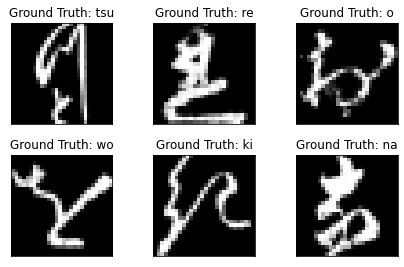

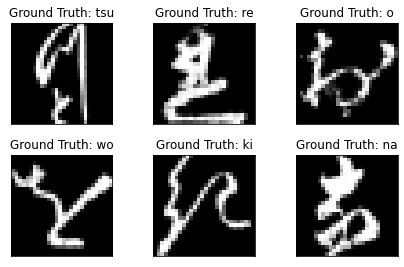

In [10]:
fig = plt.figure()
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0, :, :], cmap='gray', interpolation='none')
    plt.title(f'Ground Truth: {train_data.classes[example_targets[i]]}')
    plt.xticks([])
    plt.yticks([])
fig

## Check 2: Check Labels

In [10]:
num_classes = 10

In [11]:
train_data.classes

['o', 'ki', 'su', 'tsu', 'na', 'ha', 'ma', 'ya', 're', 'wo']

In [12]:
train_class_count = [0 for i in range(num_classes)]
for _, labels_batch in train_loader:
    for label in labels_batch:
        train_class_count[label] += 1

In [13]:
print('Train data:')
for idx, num in enumerate(train_class_count):
    print(f'Label {train_data.classes[idx]}: {num}')

Train data:
Label o: 4527
Label ki: 4500
Label su: 4547
Label tsu: 4477
Label na: 4516
Label ha: 4477
Label ma: 4534
Label ya: 4442
Label re: 4508
Label wo: 4472


In [14]:
val_class_count = [0 for i in range(num_classes)]
for _, labels_batch in val_loader:
    for label in labels_batch:
        val_class_count[label] += 1

In [15]:
print('Validation data:')
for idx, num in enumerate(val_class_count):
    print(f'Label {train_data.classes[idx]}: {num}')

Validation data:
Label o: 1473
Label ki: 1500
Label su: 1453
Label tsu: 1523
Label na: 1484
Label ha: 1523
Label ma: 1466
Label ya: 1558
Label re: 1492
Label wo: 1528


In [16]:
print('All Training data:')
total_sample = 0
for idx, num in enumerate(train_class_count):
    print(f'Label {train_data.classes[idx]}: {num + val_class_count[idx]}')
    total_sample += num + val_class_count[idx]

print()
print(f'Total samples for training data: {total_sample}')

All Training data:
Label o: 6000
Label ki: 6000
Label su: 6000
Label tsu: 6000
Label na: 6000
Label ha: 6000
Label ma: 6000
Label ya: 6000
Label re: 6000
Label wo: 6000

Total samples for training data: 60000


In [17]:
test_class_count = [0 for i in range(num_classes)]
for _, labels_batch in test_loader:
    for label in labels_batch:
        test_class_count[label] += 1

In [18]:
print('Test data:')
total_sample = 0
for idx, num in enumerate(test_class_count):
    print(f'Label {train_data.classes[idx]}: {num}')
    total_sample += num

print()
print(f'Total samples for test data: {total_sample}')

Test data:
Label o: 1000
Label ki: 1000
Label su: 1000
Label tsu: 1000
Label na: 1000
Label ha: 1000
Label ma: 1000
Label ya: 1000
Label re: 1000
Label wo: 1000

Total samples for test data: 10000


## Create Model



In [19]:
# define func to create a model
# accept parameters such as number of hidden layer and number of unit per hidden layer
class MLP(nn.Module):
    def __init__(self, hidden_layer_num, hidden_layer_unit):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(28*28, hidden_layer_unit)
        
        # use ModuleList() to add layers dynamically
        self.fc_list = nn.ModuleList()
        for i in range(hidden_layer_num):
            if i == 1:
                continue
            if i == hidden_layer_num - 1:
                break
            self.fc_list.append(nn.Linear(hidden_layer_unit, hidden_layer_unit))
        
        self.fc_last = nn.Linear(hidden_layer_unit, 10)

    def forward(self, x):
        # flatten all dimensions except the batch dimension
        x = x.view(x.shape[0],-1)  
        x = F.relu(self.fc1(x))
        
        for fc in self.fc_list:
            x = F.relu(fc(x))
        
        x = self.fc_last(x)
        return x

In [20]:
torch.cuda.is_available()

False

In [21]:
# define func to create model + criterion and chosen optimizer
def create_model(hidden_layer_num, hidden_layer_unit, optimizer_name):
    model = MLP(hidden_layer_num=hidden_layer_num, hidden_layer_unit=hidden_layer_unit)
    if torch.cuda.is_available():
        model = model.cuda()
        
    # use cross entropy loss as loss func
    criterion = nn.CrossEntropyLoss()
    if optimizer_name == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=0.01)
    elif optimizer_name == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    return model, criterion, optimizer

In [22]:
# sample model
create_model(2, 256, 'SGD')

(MLP(
   (fc1): Linear(in_features=784, out_features=256, bias=True)
   (fc_list): ModuleList(
     (0): Linear(in_features=256, out_features=256, bias=True)
   )
   (fc_last): Linear(in_features=256, out_features=10, bias=True)
 ), CrossEntropyLoss(), SGD (
 Parameter Group 0
     dampening: 0
     lr: 0.01
     maximize: False
     momentum: 0
     nesterov: False
     weight_decay: 0
 ))

In [11]:
def train_kmnist(config):
    max_epoch = 20
    
    print(config)
    model, criterion, optimizer = create_model(config['hidden_layer_num'], 
                                               config['hidden_layer_unit'], 
                                               config['optimizer_name'])

    train_losses_minibatches = []
    train_losses_epoch = []
    val_losses = []
    
    # for early stopping
    # after 2 epoch of no improvement of validation loss, stop training
    # to prevent from overfitting
    no_improve_counter = 0
    lowest_val_error = sys.maxsize
    patience = 2

    for epoch in range(max_epoch):
        # TRAIN
        model.train()
        epoch_losses = 0
        for batch_idx, (data, target) in enumerate(train_loader):
            if torch.cuda.is_available():
                data, target = data.cuda(), target.cuda()

            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
        
            train_losses_minibatches.append(loss.item())
            epoch_losses += loss.item()
 
        train_losses_epoch.append(epoch_losses)
        
        # EVALUATION
        # check in validation set
        model.eval()
        val_loss = 0
        correct_train = 0
        correct_val = 0
        correct_test = 0
        with torch.no_grad():
            # calculate accuracy on train set
            for data, target in train_loader:
                if torch.cuda.is_available():
                   data, target = data.cuda(), target.cuda()

                output = model(data)
                val_loss += criterion(output, target).item()
                pred = output.data.max(1, keepdim=True)[1]
                correct_train += pred.eq(target.data.view_as(pred)).sum()


            # calculate accuracy on validation set
            for data, target in val_loader:
                if torch.cuda.is_available():
                   data, target = data.cuda(), target.cuda()

                output = model(data)
                val_loss += criterion(output, target).item()
                pred = output.data.max(1, keepdim=True)[1]
                correct_val += pred.eq(target.data.view_as(pred)).sum()

            val_loss /= len(val_loader.dataset)
            val_losses.append(val_loss)

            if val_loss <= lowest_val_error:
                lowest_val_error = val_loss
                no_improve_counter = 0
            else:
                no_improve_counter += 1

            # calculate accuracy on test set
            for data, target in test_loader:
                if torch.cuda.is_available():
                   data, target = data.cuda(), target.cuda()

                output = model(data)
                pred = output.data.max(1, keepdim=True)[1]
                correct_test += pred.eq(target.data.view_as(pred)).sum()
            
            tune.report(train_accuracy=100. * correct_train.item() / len(train_loader.dataset), 
                        val_accuracy=100. * correct_val.item() / len(val_loader.dataset), 
                        test_accuracy=100. * correct_test.item() / len(test_loader.dataset),
                        epoch=epoch)
            
            # early stopping
            if no_improve_counter >= patience:
                break

## Hyperparameter Tuning

In [71]:
%%time
# use raytune to run hyperparameter tuning
# a few hyperparameter value is inserted to be explored
# total number of model combination will be 12 (3c1 x 2c1 x 2c1)

analysis = tune.run(
    train_kmnist, config={
        'hidden_layer_num': tune.grid_search([1, 3, 5]),
        'hidden_layer_unit': tune.grid_search([128, 256]),
        'optimizer_name': tune.grid_search(['SGD', 'Adam'])
        }, resources_per_trial={'gpu': 1}, verbose=0)

2022-05-29 07:16:04,334	INFO trial_runner.py:803 -- starting train_kmnist_2f428_00000
2022-05-29 07:16:04,916	WARNING worker.py:1382 -- Warning: The actor ImplicitFunc is very large (53 MiB). Check that its definition is not implicitly capturing a large array or other object in scope. Tip: use ray.put() to put large objects in the Ray object store.
2022-05-29 07:16:05,976	WARNING util.py:171 -- The `start_trial` operation took 1.640 s, which may be a performance bottleneck.


(train_kmnist pid=2124) {'hidden_layer_num': 1, 'hidden_layer_unit': 128, 'optimizer_name': 'SGD'}


2022-05-29 07:20:12,838	INFO trial_runner.py:803 -- starting train_kmnist_2f428_00001


(train_kmnist pid=2258) {'hidden_layer_num': 3, 'hidden_layer_unit': 128, 'optimizer_name': 'SGD'}


2022-05-29 07:24:16,877	INFO trial_runner.py:803 -- starting train_kmnist_2f428_00002


(train_kmnist pid=2410) {'hidden_layer_num': 5, 'hidden_layer_unit': 128, 'optimizer_name': 'SGD'}


2022-05-29 07:27:33,911	INFO trial_runner.py:803 -- starting train_kmnist_2f428_00003


(train_kmnist pid=2533) {'hidden_layer_num': 1, 'hidden_layer_unit': 256, 'optimizer_name': 'SGD'}


2022-05-29 07:31:30,966	INFO trial_runner.py:803 -- starting train_kmnist_2f428_00004


(train_kmnist pid=2686) {'hidden_layer_num': 3, 'hidden_layer_unit': 256, 'optimizer_name': 'SGD'}


2022-05-29 07:35:37,007	INFO trial_runner.py:803 -- starting train_kmnist_2f428_00005


(train_kmnist pid=2838) {'hidden_layer_num': 5, 'hidden_layer_unit': 256, 'optimizer_name': 'SGD'}


2022-05-29 07:39:56,045	INFO trial_runner.py:803 -- starting train_kmnist_2f428_00006


(train_kmnist pid=2988) {'hidden_layer_num': 1, 'hidden_layer_unit': 128, 'optimizer_name': 'Adam'}


2022-05-29 07:42:25,078	INFO trial_runner.py:803 -- starting train_kmnist_2f428_00007


(train_kmnist pid=3098) {'hidden_layer_num': 3, 'hidden_layer_unit': 128, 'optimizer_name': 'Adam'}


2022-05-29 07:44:36,098	INFO trial_runner.py:803 -- starting train_kmnist_2f428_00008


(train_kmnist pid=3200) {'hidden_layer_num': 5, 'hidden_layer_unit': 128, 'optimizer_name': 'Adam'}


2022-05-29 07:46:43,115	INFO trial_runner.py:803 -- starting train_kmnist_2f428_00009


(train_kmnist pid=3294) {'hidden_layer_num': 1, 'hidden_layer_unit': 256, 'optimizer_name': 'Adam'}


2022-05-29 07:48:50,127	INFO trial_runner.py:803 -- starting train_kmnist_2f428_00010


(train_kmnist pid=3388) {'hidden_layer_num': 3, 'hidden_layer_unit': 256, 'optimizer_name': 'Adam'}


2022-05-29 07:51:02,141	INFO trial_runner.py:803 -- starting train_kmnist_2f428_00011


(train_kmnist pid=3474) {'hidden_layer_num': 5, 'hidden_layer_unit': 256, 'optimizer_name': 'Adam'}
CPU times: user 30 s, sys: 5.71 s, total: 35.7 s
Wall time: 37min 1s


In [72]:
df = analysis.dataframe()
df.head()

,train_accuracy,val_accuracy,test_accuracy,epoch,time_this_iter_s,done,timesteps_total,episodes_total,training_iteration,trial_id,...,hostname,node_ip,time_since_restore,timesteps_since_restore,iterations_since_restore,warmup_time,config/hidden_layer_num,config/hidden_layer_unit,config/optimizer_name,logdir
0,94.360000,92.973333,83.56,19,11.414748,False,NaN,NaN,20,2f428_00000,...,402ae5c8602e,172.28.0.2,242.120171,0,20,0.011972,1,128,SGD,/root/ray_results/train_kmnist_2022-05-29_07-1...
1,96.875556,94.153333,86.55,19,11.875785,False,NaN,NaN,20,2f428_00001,...,402ae5c8602e,172.28.0.2,241.040340,0,20,0.003013,3,128,SGD,/root/ray_results/train_kmnist_2022-05-29_07-1...
2,95.917778,92.933333,83.77,14,12.590681,False,NaN,NaN,15,2f428_00002,...,402ae5c8602e,172.28.0.2,193.274626,0,15,0.003040,5,128,SGD,/root/ray_results/train_kmnist_2022-05-29_07-1...
3,95.048889,93.526667,84.90,19,11.362148,False,NaN,NaN,20,2f428_00003,...,402ae5c8602e,172.28.0.2,234.198379,0,20,0.003107,1,256,SGD,/root/ray_results/train_kmnist_2022-05-29_07-1...
4,97.404444,94.740000,86.88,19,11.862994,False,NaN,NaN,20,2f428_00004,...,402ae5c8602e,172.28.0.2,242.416913,0,20,0.003681,3,256,SGD,/root/ray_results/train_kmnist_2022-05-29_07-1...


In [73]:
df.columns

Index(['train_accuracy', 'val_accuracy', 'test_accuracy', 'epoch',
       'time_this_iter_s', 'done', 'timesteps_total', 'episodes_total',
       'training_iteration', 'trial_id', 'experiment_id', 'date', 'timestamp',
       'time_total_s', 'pid', 'hostname', 'node_ip', 'time_since_restore',
       'timesteps_since_restore', 'iterations_since_restore', 'warmup_time',
       'config/hidden_layer_num', 'config/hidden_layer_unit',
       'config/optimizer_name', 'logdir'],
      dtype='object')

In [74]:
# select important columns only
df = df[['config/hidden_layer_num', 'config/hidden_layer_unit', 'config/optimizer_name', 'train_accuracy', 'val_accuracy', 'test_accuracy', 'epoch', 'time_total_s']]

In [75]:
df = df.sort_values('val_accuracy', ascending=False)
df

,config/hidden_layer_num,config/hidden_layer_unit,config/optimizer_name,train_accuracy,val_accuracy,test_accuracy,epoch,time_total_s
11,5,256,Adam,99.037778,96.066667,89.43,7,112.714998
10,3,256,Adam,99.075556,95.753333,89.04,9,128.891190
8,5,128,Adam,98.517778,95.313333,88.50,8,123.507330
7,3,128,Adam,99.388889,95.280000,89.40,9,128.092762
9,1,256,Adam,99.088889,95.226667,88.10,9,123.297398
4,3,256,SGD,97.404444,94.740000,86.88,19,242.416913
5,5,256,SGD,99.233333,94.613333,86.37,19,255.874643
6,1,128,Adam,98.815556,94.373333,86.68,11,146.095783
1,3,128,SGD,96.875556,94.153333,86.55,19,241.040340
3,1,256,SGD,95.048889,93.526667,84.90,19,234.198379


In [76]:
df.rename(columns = {'config/hidden_layer_num':'hidden_layer_number', 
                      'config/hidden_layer_unit':'hidden_unit_per_layer',
                      'config/optimizer_name': 'optimizer',
                      'time_total_s': 'training time (s)'
                      }, inplace=True)

In [77]:
df['minibacth_size'] = 32
df['training_size'] = 45000
df['validation_size'] = 15000
df['test_size'] = 10000

df['learning_rate'] = df['optimizer'].apply(lambda x: 0.01 if x=='SGD' else 0.001)

In [16]:
# hyperparameter table
df

,hidden_layer_number,hidden unit per layer,optimizer,train_accuracy,val_accuracy,test_accuracy,epoch,training time (s),minibacth_size,training_size,validation_size,test_size,learning_rate
0,5,256,Adam,99.037778,96.066667,89.43,7,112.714998,32,45000,15000,10000,0.001
1,3,256,Adam,99.075556,95.753333,89.04,9,128.891190,32,45000,15000,10000,0.001
2,5,128,Adam,98.517778,95.313333,88.50,8,123.507330,32,45000,15000,10000,0.001
3,3,128,Adam,99.388889,95.280000,89.40,9,128.092762,32,45000,15000,10000,0.001
4,1,256,Adam,99.088889,95.226667,88.10,9,123.297398,32,45000,15000,10000,0.001
5,3,256,SGD,97.404444,94.740000,86.88,19,242.416913,32,45000,15000,10000,0.010
6,5,256,SGD,99.233333,94.613333,86.37,19,255.874643,32,45000,15000,10000,0.010
7,1,128,Adam,98.815556,94.373333,86.68,11,146.095783,32,45000,15000,10000,0.001
8,3,128,SGD,96.875556,94.153333,86.55,19,241.040340,32,45000,15000,10000,0.010
9,1,256,SGD,95.048889,93.526667,84.90,19,234.198379,32,45000,15000,10000,0.010


In [79]:
df.to_excel('hyperparameter_result_v2.xlsx', index=False)
from google.colab import files
files.download('hyperparameter_result_v2.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [14]:
from google.colab import files
uploaded = files.upload()

Saving hyperparameter_result_v2.xlsx to hyperparameter_result_v2.xlsx


In [15]:
df = pd.read_excel('hyperparameter_result_v2.xlsx')

## Check 4: Training and Test Accuracy

In [88]:
def print_model_accuracy(row):
    print(f'Model {row.name + 1}: {row["hidden_layer_number"]} hidden layer, {row["hidden unit per layer"]} hidden unit per layer, {row["optimizer"]} optimizer')
    print('Training:')
    print(f'  Number of data: {len(train)}')
    print(f'  Number of wrong predicted: {len(train) - (int(row["train_accuracy"] / 100 * len(train)))}')
    print(f'  Accuracy: {row["train_accuracy"]:.2f} %')
    print('Validation:')
    print(f'  Number of data: {len(val)}')
    print(f'  Number of wrong predicted: {len(val) - (int(row["val_accuracy"] / 100 * len(val)))}')
    print(f'  Accuracy: {row["val_accuracy"]:.2f} %')
    print('Test:')
    print(f'  Number of data: {len(test_data)}')
    print(f'  Number of wrong predicted: {len(test_data) - (int(row["test_accuracy"] / 100 * len(test_data)))}')
    print(f'  Accuracy: {row["test_accuracy"]:.2f} %')
    print()

In [89]:
# check 4
df.apply(print_model_accuracy, axis=1);

Model 1: 5 hidden layer, 256 hidden unit per layer, Adam optimizer
Training:
  Number of data: 45000
  Number of wrong predicted: 433
  Accuracy: 99.04 %
Validation:
  Number of data: 15000
  Number of wrong predicted: 590
  Accuracy: 96.07 %
Test:
  Number of data: 10000
  Number of wrong predicted: 1057
  Accuracy: 89.43 %

Model 2: 3 hidden layer, 256 hidden unit per layer, Adam optimizer
Training:
  Number of data: 45000
  Number of wrong predicted: 416
  Accuracy: 99.08 %
Validation:
  Number of data: 15000
  Number of wrong predicted: 638
  Accuracy: 95.75 %
Test:
  Number of data: 10000
  Number of wrong predicted: 1096
  Accuracy: 89.04 %

Model 3: 5 hidden layer, 128 hidden unit per layer, Adam optimizer
Training:
  Number of data: 45000
  Number of wrong predicted: 667
  Accuracy: 98.52 %
Validation:
  Number of data: 15000
  Number of wrong predicted: 704
  Accuracy: 95.31 %
Test:
  Number of data: 10000
  Number of wrong predicted: 1150
  Accuracy: 88.50 %

Model 4: 3 hidde

## Train Model with selected Hyperparameters

In [61]:
model, criterion, optimizer = create_model(5, 256, 'Adam')

In [62]:
max_num_epoch = 20
log_interval = 200

train_losses_minibatches = []
train_losses_epoch = []
val_losses = []

train_accuracy = []
val_accuracy = []

lowest_val_error = sys.maxsize
patience = 2

In [63]:
def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
    
        train_losses_minibatches.append(loss.item())

        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [64]:
def evaluate():
    model.eval()
    val_loss = 0
    train_loss = 0
    correct_train = 0
    correct_val = 0
    with torch.no_grad():
          # calculate accuracy on train set
          for data, target in train_loader:
              if torch.cuda.is_available():
                  data, target = data.cuda(), target.cuda()

              output = model(data)
              train_loss += criterion(output, target).item()
              pred = output.data.max(1, keepdim=True)[1]
              correct_train += pred.eq(target.data.view_as(pred)).sum()

          train_loss /= len(train_loader.dataset)
          train_losses_epoch.append(train_loss)
          train_accuracy.append(100. * correct_train.item() / len(train_loader.dataset))

          # calculate accuracy on valdiation set
          for data, target in val_loader:
              if torch.cuda.is_available():
                  data, target = data.cuda(), target.cuda()

              output = model(data)
              val_loss += criterion(output, target).item()
              pred = output.data.max(1, keepdim=True)[1]
              correct_val += pred.eq(target.data.view_as(pred)).sum()

          val_loss /= len(val_loader.dataset)
          val_losses.append(val_loss)
          val_accuracy.append(100. * correct_val.item() / len(val_loader.dataset))

          print('Training set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
              train_loss, correct_train, len(train_loader.dataset),
              100. * correct_train.item() / len(train_loader.dataset)))
          print('Validation set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
              val_loss, correct_val, len(val_loader.dataset),
              100. * correct_val.item() / len(val_loader.dataset)))
      
    return val_loss

In [65]:
no_improve_counter = 0
evaluate()
for epoch in range(max_num_epoch):
    train(epoch)
    loss = evaluate()
    if loss <= lowest_val_error:
        lowest_val_error = loss
        no_improve_counter = 0
    else:
        no_improve_counter += 1
    
    if no_improve_counter >= patience:
        print(f'Early stopping at epoch: {epoch} because no decrement in the validation loss.')
        break

Training set: Avg. loss: 0.0720, Accuracy: 4508/45000 (10%)
Validation set: Avg. loss: 0.0720, Accuracy: 1492/15000 (10%)

Train Epoch: 0 [0/45000 (0%)]	Loss: 2.303945
Train Epoch: 0 [6400/45000 (14%)]	Loss: 0.326471
Train Epoch: 0 [12800/45000 (28%)]	Loss: 0.611550
Train Epoch: 0 [19200/45000 (43%)]	Loss: 0.140433
Train Epoch: 0 [25600/45000 (57%)]	Loss: 0.292165
Train Epoch: 0 [32000/45000 (71%)]	Loss: 0.371853
Train Epoch: 0 [38400/45000 (85%)]	Loss: 0.354035
Train Epoch: 0 [44800/45000 (100%)]	Loss: 0.063282
Training set: Avg. loss: 0.0065, Accuracy: 42137/45000 (94%)
Validation set: Avg. loss: 0.0073, Accuracy: 13901/15000 (93%)

Train Epoch: 1 [0/45000 (0%)]	Loss: 0.252221
Train Epoch: 1 [6400/45000 (14%)]	Loss: 0.332521
Train Epoch: 1 [12800/45000 (28%)]	Loss: 0.122460
Train Epoch: 1 [19200/45000 (43%)]	Loss: 0.253763
Train Epoch: 1 [25600/45000 (57%)]	Loss: 0.065496
Train Epoch: 1 [32000/45000 (71%)]	Loss: 0.269109
Train Epoch: 1 [38400/45000 (85%)]	Loss: 0.108857
Train Epoch: 

## Check 3: Losses Visualisation

### Losses of every minibatches


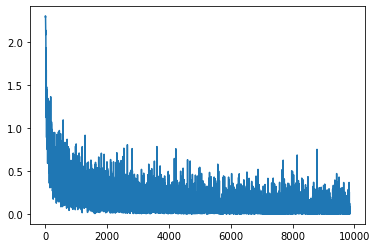

In [66]:
plt.plot(train_losses_minibatches)

### Losses of every epoch

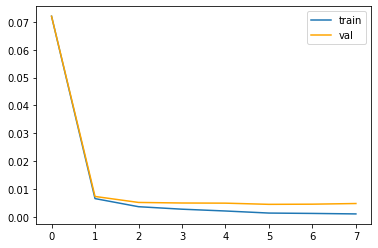

In [67]:
plt.plot(train_losses_epoch)
plt.plot(val_losses, color='orange')
plt.legend(['train', 'val'])

### Accuracy after of every epoch

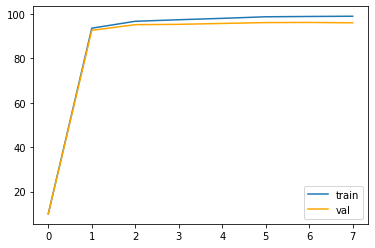

In [68]:
plt.plot(train_accuracy)
plt.plot(val_accuracy, color='orange')
plt.legend(['train', 'val'])

### Accuracy on Test Set

In [69]:
model.eval()
test_loss = 0
correct_test = 0

with torch.no_grad():
    for data, target in test_loader:
        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()

        output = model(data)
        test_loss += criterion(output, target).item()
        pred = output.data.max(1, keepdim=True)[1]
        correct_test += pred.eq(target.data.view_as(pred)).sum()

    test_loss /= len(test_loader.dataset)

    print('Test set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        test_loss, correct_test, len(test_loader.dataset),
        100. * correct_test.item() / len(test_loader.dataset)))

Test set: Avg. loss: 0.0148, Accuracy: 8989/10000 (90%)


# Task 2

In [63]:
def compute_probability_dist(dataset):
    # convert tensor to numpy
    dataset_np = dataset.data.numpy()
    # flatten the array
    dataset_np = np.reshape(dataset_np, (-1, 28*28))

    # create an array to store the value of probability of the value of each pixel
    # pixel_probab.shape = (784, 256)
    pixel_proba = np.array([[0. for j in range(256)] for i in range(28*28)])
    
    for i in range(28*28):
        pixel_i = dataset_np[:, i]

        # count the value contain in each pixel and divide by total length to get the probability
        unique_count = np.unique(pixel_i, return_counts=True)
        
        for idx, value in enumerate(unique_count[0]):
            pixel_proba[i][value] = unique_count[1][idx]/len(dataset_np)

    return pixel_proba


### Q1 Probability on Training Data

In [64]:
train_pixel_proba = compute_probability_dist(train_data)

In [65]:
# peek into the training pixel probability array
train_pixel_proba[0][:20]

array([9.94100000e-01, 5.00000000e-04, 2.66666667e-04, 2.83333333e-04,
       1.50000000e-04, 1.66666667e-04, 1.83333333e-04, 1.00000000e-04,
       5.00000000e-05, 1.00000000e-04, 1.00000000e-04, 6.66666667e-05,
       5.00000000e-05, 1.33333333e-04, 1.33333333e-04, 3.33333333e-05,
       8.33333333e-05, 8.33333333e-05, 6.66666667e-05, 3.33333333e-05])

### Q2 Probability on Test Data

In [66]:
test_pixel_proba = compute_probability_dist(test_data)

In [67]:
# peek into the test pixel probability array
test_pixel_proba[0][:20]

array([9.949e-01, 3.000e-04, 1.000e-04, 1.000e-04, 2.000e-04, 2.000e-04,
       3.000e-04, 1.000e-04, 3.000e-04, 1.000e-04, 2.000e-04, 1.000e-04,
       1.000e-04, 2.000e-04, 1.000e-04, 0.000e+00, 0.000e+00, 0.000e+00,
       2.000e-04, 0.000e+00])

### Q3 Visualize probability for pixel #123

In [68]:
# make sure that the total of probability is 1
print(train_pixel_proba[123].sum())
print(test_pixel_proba[123].sum())

1.0000000000000002
0.9999999999999998


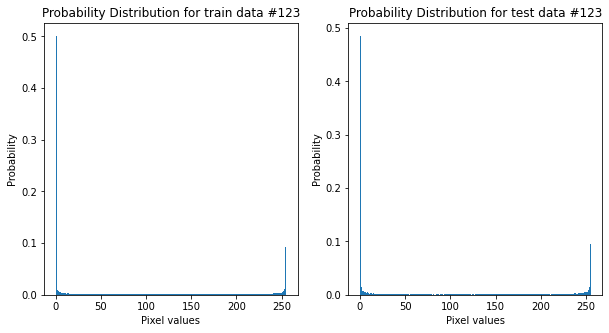

In [69]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.hist(x=[i for i in range(256)], bins=256, weights=train_pixel_proba[123]);
ax1.set_title('Probability Distribution for train data #123')
ax1.set_xlabel("Pixel values")
ax1.set_ylabel("Probability")

ax2.hist(x=[i for i in range(256)], bins=256, weights=test_pixel_proba[123]);
ax2.set_title('Probability Distribution for test data #123')
ax2.set_xlabel("Pixel values")
ax2.set_ylabel("Probability");

### Q4a Compute the Shannon Entropy

In [70]:
def shannon_log(x):
    return -1 * x * math.log(x, 2)

In [71]:
def compute_entropy(probability_dist):
    entropies = []

    for proba in probability_dist:
        entropy = [shannon_log(x) for x in proba if x>0]
        entropies.append(sum(entropy))

    total_entropy = sum(entropies)

    return np.array(entropies), total_entropy

In [72]:
train_entropy_list, train_total_entropy = compute_entropy(train_pixel_proba)
print(f'Entropy for train data H(x): {train_total_entropy}')

Entropy for train data H(x): 2447.150658798105


In [73]:
test_entropy_list, test_total_entropy = compute_entropy(test_pixel_proba)
print(f'Entropy for test data H(x): {test_total_entropy}')

Entropy for test data H(x): 2407.1840029090063


In [74]:
print(train_entropy_list.shape)
train_entropy_list[:20]

(784,)


array([0.0895588 , 0.16458159, 0.26130604, 0.39351536, 0.59963562,
       0.87885991, 1.23728993, 1.62892182, 2.03865259, 2.43851124,
       2.825307  , 3.20288528, 3.4651016 , 3.55357147, 3.41686392,
       3.07092999, 2.54436874, 1.99952839, 1.60492879, 1.32814015])

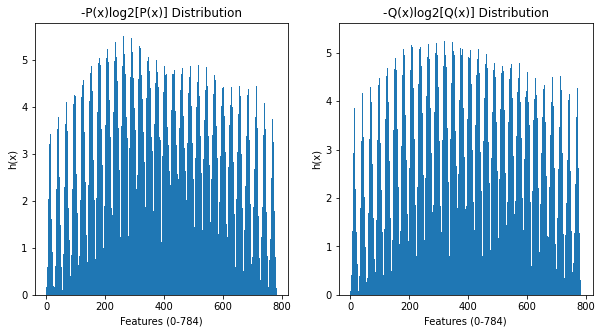

In [75]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.hist(x=[i for i in range(784)], bins=784, weights=train_entropy_list);
ax1.set_title('-P(x)log2[P(x)] Distribution')
ax1.set_xlabel("Features (0-784)")
ax1.set_ylabel("h(x)")

ax2.hist(x=[i for i in range(784)], bins=784, weights=test_entropy_list);
ax2.set_title('-Q(x)log2[Q(x)] Distribution')
ax2.set_xlabel("Features (0-784)")
ax2.set_ylabel("h(x)");

### Q4b What is the best way to measure the difference between entropy of training vs test dataset that you have computed?

The best way to measure the difference between entropy of training vs test dataset is by compute the total entropy of each feature and compared it between the train and test set. After we get a table of differences between each feature, we could evaluate between the most and the least important feature in the dataset.

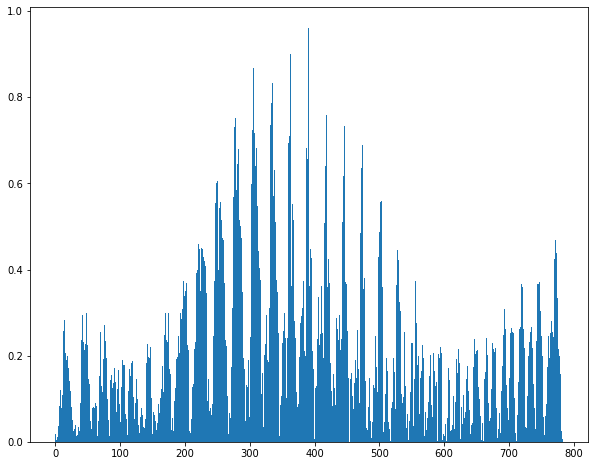

In [76]:
plt.figure(figsize=(10,8))
entropy_diff = np.array(abs(train_entropy_list-test_entropy_list))
plt.hist(x=[i for i in range(784)], bins=784, weights=entropy_diff);

In [77]:
top_20_entropy_diff = np.argsort(-entropy_diff)[:20]
print(f'Features with the highest amount of difference in entropy: {top_20_entropy_diff}')

Features with the highest amount of difference in entropy: [391 419 363 447 306 334 335 362 305 333 390 277 418 475 278 332 446 276
 304 307]


In [78]:
bottom_20_entropy_diff = np.argsort(entropy_diff)[:20]
print(f'Features with the lowest amount of difference in entropy: {bottom_20_entropy_diff}')

Features with the lowest amount of difference in entropy: [699 454 712 517 453 661 135   2 590 604 658 727 545 181 598   1 617 611
 400  33]


We can see that feature #391 has the highest amount of difference in entropy. This means that this particular feature have a high contribution in identifying the label.


In [84]:
entropy_diff.reshape(28, 28).shape

(28, 28)

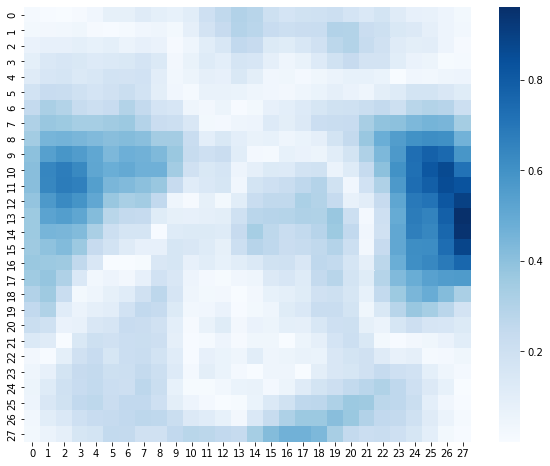

In [87]:
plt.figure(figsize=(10,8))
sns.heatmap(entropy_diff.reshape(28, 28), cmap='Blues')

Figure above shows the intensity of difference in feature. The higher the entropy differences, the darker the pixel colour. We can see that there are certain spots that have really high intensities such as middle right and middle left. This could mean that this area is very important in determining the label.

